In [75]:
from mpetools import IslandTime, TimeSeriesPreProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
from scipy import stats
import cv2
import numpy.ma as ma
from shapely.geometry import Polygon, LineString, Point
import os
import zipfile
from scipy.signal import savgol_filter
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import pymannkendall as mk
import statsmodels.api as sm
import tsfresh
import shapely
import pickle
from osgeo import gdal
from coastsatmaster.coastsat import SDS_preprocess, SDS_tools
import matplotlib
%matplotlib qt
from skimage.filters import threshold_multiotsu
# image processing modules
import skimage.filters as filters
import skimage.measure as measure
import skimage.morphology as morphology
import skimage.metrics as metrics
from celluloid import Camera
from statsmodels.tsa.seasonal import STL, seasonal_decompose

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def get_timeseries(island, country, island_info):
    fig = plt.figure()
    camera = Camera(fig)
    # Open metadata file
    metadata = pickle.load(open(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), '{}_{}_metadata.pkl'.format(island, country)), 'rb'))

    # Retrieve settings
    settings = island_info['timeseries_coastsat']['settings']
    
    idx_sat = 0

    # Reference shoreline
    reference_shoreline = island_info['spatial_reference']['reference_shoreline']

    # Loop in every satellite
    for sat in ['S2']:
        print(sat)
        buff = island_info['spatial_reference']['reference_shoreline_buffer_{}'.format(sat)]
        buff_nan = np.where(buff == 0., np.nan, buff)

        # Empty metadata for this satellite
        if metadata[sat]['filenames'] == []:
            continue

        # File path and names from CoastSat folder
        filepath = SDS_tools.get_filepath(settings['inputs'], sat)
        filenames = metadata[sat]['filenames']

        # Loop through images within the folder (taken from SDS_classify.py)
        for idx_img in range(len(filenames)):
            # Get file name
            fn = SDS_tools.get_filenames(filenames[idx_img], filepath, sat)

            # Retrieve information about image
            im_ms, georef, cloud_mask, _, _, im_nodata = SDS_preprocess.preprocess_single(fn, sat, settings['cloud_mask_issue'], settings['pan_off'], 'C02')

            # Compute cloud_cover percentage (with no data pixels)
            cloud_cover_combined = np.divide(sum(sum(cloud_mask.astype(int))), (cloud_mask.shape[0] * cloud_mask.shape[1]))
            
            # If 99% of cloudy pixels in image -> skip
            if cloud_cover_combined > 0.99: 
                continue
                
            image_epsg = metadata[sat]['epsg'][idx_img]

            # Remove no data pixels from the cloud mask (for example L7 bands of no data should not be accounted for)
            cloud_mask_adv = np.logical_xor(cloud_mask, im_nodata)

            # Compute updated cloud cover percentage (without no data pixels)
            cloud_cover = np.divide(sum(sum(cloud_mask_adv.astype(int))), (sum(sum((~im_nodata).astype(int)))))

            # Skip image if cloud cover is above threshold
            if cloud_cover > settings['cloud_thresh'] or cloud_cover == 1:
                continue

            # Get NDVI image
            img_NDVI = SDS_tools.nd_index(im_ms[:, :, 3], im_ms[:, :, 2], cloud_mask)
            img_MNDWI = SDS_tools.nd_index(im_ms[:, :, 4], im_ms[:, :, 1], cloud_mask)

            wimg_masked = buff_nan * img_MNDWI
            #plt.figure()
            #plt.imshow(img_MNDWI)
            marr = ma.masked_array(img_MNDWI, buff)

            #plt.hist(wimg_masked[~np.isnan(wimg_masked)].flatten(), bins=100)
            
            to = threshold_multiotsu(wimg_masked[~np.isnan(wimg_masked)].flatten().reshape(-1, 1), classes=3)

            for idx_t, t in enumerate(to):
                contours = measure.find_contours(wimg_masked, t, fully_connected='high', positive_orientation='high')
                
                plt.imshow(img_MNDWI)
                argm = np.argsort([len(c) for c in contours])
                for ii, cc in enumerate(contours):
                    #if argm[ii] == 0 or argm[ii] == 1:
                        #cc_epsg = SDS_tools.convert_epsg(SDS_tools.convert_pix2world(cc, georef), image_epsg, 3857)
                    if idx_t == 0:
                        plt.plot(cc[:, 1], cc[:, 0], color='k', marker='.')
                    else:
                        plt.plot(cc[:, 1], cc[:, 0], color='r', marker='.')
                        '''
                        dist_ref = [Point(cc_epsg[i, 0], cc_epsg[i, 1]).distance(LineString(reference_shoreline)) for i in range(len(cc_epsg))]
                        dist_ref_zscores = stats.zscore(dist_ref)

                        if idx_t == 0:
                            for i in range(len(cc_epsg)):
                                if dist_ref_zscores[i] < 5:
                                    plt.scatter(cc[i, 1], cc[i, 0], marker='.', color='k')
                                else:
                                    plt.scatter(cc[i, 1], cc[i, 0], marker='.', color='r')
                            #plt.text(0, 0, filenames[idx_img])
                        else:
                            for i in range(len(cc_epsg)):
                                if dist_ref_zscores[i] < 5:
                                    plt.scatter(cc[i, 1], cc[i, 0], marker='.', color='g')
                                else:
                                    plt.scatter(cc[i, 1], cc[i, 0], marker='.', color='orange')
                            #plt.plot(cc[:, 1], cc[:, 0], linewidth=2, color='r')
                        '''
                    #else:
                        #plt.plot(cc[:, 1], cc[:, 0], linewidth=2, color='r')
                    #cc_epsg = SDS_tools.convert_epsg(SDS_tools.convert_pix2world(cc, georef), image_epsg, 3857)
                    #pol1 = LineString(cc_epsg)
                    #print(pol1.is_valid)
                    #if not pol1.is_valid:
                        #coo = pol1.exterior.coords[:-2]
                        #pol1 = Polygon(coo)

                    #print(pol1)
                    #for poly in pol1.geoms:
                    #   x, y = poly.exterior.xy
                    #  plt.plot(x, y, linewidth=2, marker='.')
                    #x, y = pol1.xy
                    #plt.plot(x, y, linewidth=2, marker='.')
                    #plt.imshow(pol1)
                    #pol2 = Polygon(island_info['spatial_reference']['reference_shoreline'])

                    #inter = pol1.intersection(pol2).area
                    #print(inter)
                #plt.title(filenames[idx_img])
            camera.snap()
            
    animation = camera.animate(interval = 1)
    animation.save('shoreline_vegline.gif')
            #return img_NDVI, img_MNDWI


In [31]:
IslandTime.TimeSeriesCoastSat('Vodamulaa', 'Maldives', overwrite=True).main()


-------------------------------------------------------------------
Retrieving all information available for the island.
Island: Vodamulaa, Maldives
-------------------------------------------------------------------

~ The following information is available: ~

general_info
               island
               country
               atoll
spatial_reference
               latitude
               longitude
               polygon
               reference_shoreline
               transects
               area_country
               reference_shoreline_buffer_L8
               reference_shoreline_buffer_L9
               reference_shoreline_buffer_S2
image_collection_dict
               description
               S2
               L7
               L8
               L9
duvat_magnan_2019
               atoll
               island number
               satellite image date (d/m/y) 2004-2006
               satellite image date (d/m/y) 2014-2016
               change in island land area (data

In [32]:
#IslandTime.TimeSeriesCoastSat('Keredhdhoo', 'Maldives', overwrite=True).main()
#IslandTime.TimeSeriesVegetation('Vodamulaa', 'Maldives', overwrite=True).main()
island_info = IslandTime.retrieve_island_info('Vodamulaa', 'Maldives', verbose=False)

In [53]:
island_info = TimeSeriesPreProcess.TimeSeriesPreProcess(island_info).main()


-------------------------------------------------------------------
Time series pre-processing
Island: Vodamulaa, Maldives
-------------------------------------------------------------------



In [118]:
for yr in range(2013, 2023):
    dr = pd.date_range(datetime.datetime(yr, 3, 31), datetime.datetime(yr, 10, 1), freq='M')
    df_dr = pd.DataFrame(index=dr)
    
    if yr == 2013:
        df_dr_t = df_dr
    
    else:
        df_dr_t = pd.concat([df_dr_t, df_dr])

df_dr_t.index = [pytz.utc.localize(df_dr_t.index[i]) for i in range(len(df_dr_t.index))]

In [119]:
for i in range(50):
    try:
        plt.figure()
        ts = island_info['timeseries_preprocessing']['optimal time period']['dict_timeseries']['coastline_position_transect_{}_waterline'.format(i)]['monthly']['coastline_position_transect_{}_waterline'.format(i)]
        ts.plot()
        condition = ts.index.isin(df_dr_t.index)
        mask = pd.Series(condition, index=ts.index)
        masked_df = ts.where(mask, np.nan)
        other_df = ts.where(~mask, np.nan)
        
        decomp = STL(ts, period=12).fit()
        decomp.trend.plot()
        for yr in range(2013, 2023):
            if yr == 2013:
                plt.fill_between(pd.date_range(datetime.datetime(yr, 4, 1), datetime.datetime(yr, 9, 1), freq='M'), min(ts), max(ts), color='orange', alpha=0.2, label='Indian Monsoon')
            else:
                plt.fill_between(pd.date_range(datetime.datetime(yr, 4, 1), datetime.datetime(yr, 9, 1), freq='M'), min(ts), max(ts), color='orange', alpha=0.2)
        plt.title('Transect {}'.format(i))
        plt.show()
        plt.figure()
        plt.boxplot([masked_df.dropna(), other_df.dropna()])
        plt.show()
    except:
        continue

In [68]:
IslandTime.plot_shoreline_transects(island_info)

In [72]:
for i in range(36, 50):
    try:
        plt.figure()
        plt.title('Transect {}'.format(i))
        island_info['timeseries_coastsat']['timeseries']['coastline_position_transect_{}_waterline'.format(i)].plot()
        island_info['timeseries_coastsat']['timeseries']['coastline_position_transect_{}_vegline'.format(i)].plot()
        island_info['timeseries_coastsat']['timeseries']['coastline_position_transect_{}_waterline_no_outliers'.format(i)].plot()
        island_info['timeseries_coastsat']['timeseries']['coastline_position_transect_{}_vegline_no_outliers'.format(i)].plot()

    except:
        continue

In [9]:
get_timeseries('Vodamulaa', 'Maldives', island_info)

S2


MovieWriter ffmpeg unavailable; using Pillow instead.


In [17]:
iimg, wimg = get_timeseries('Vodamulaa', 'Maldives', island_info)
buff = island_info['spatial_reference']['reference_shoreline_buffer_S2']

S2


In [18]:
masked_wimg = np.multiply(wimg, buff)
buff_nan = np.where(buff == 0., np.nan, buff)
wimg_masked = buff_nan * wimg
#plt.scatter(np.argmax(np.abs(np.diff(savgol_filter(iimg[110,:], 20, 2)))), 110, color='k')

In [19]:
marr = ma.masked_array(wimg, buff)
to = threshold_multiotsu(marr.compressed(), classes=4)
plt.hist(marr.compressed(), bins=100)
plt.axvline(to[0], color='k')
plt.axvline(to[1], color='k')
plt.axvline(to[2], color='k')

In [34]:
contours = measure.find_contours(wimg_masked, to[1], fully_connected='high', positive_orientation='high')
plt.imshow(wimg)

for cc in contours:
    plt.plot(cc[:, 1], cc[:, 0], linewidth=2, marker='.')


In [30]:
measure.approximate_polygon(contours[0], tolerance=2)

array([[ 86.        , 145.57545121],
       [ 90.58261089, 146.        ],
       [ 80.        , 111.65974724],
       [ 55.28709323,  55.        ],
       [ 58.        ,  40.50369885],
       [ 63.        ,  48.44252496],
       [ 89.        ,  71.88506369],
       [116.20293828, 114.        ],
       [120.36695525, 136.        ],
       [100.23099194, 151.        ],
       [ 96.48489807, 157.        ],
       [ 99.        , 157.86039901]])

In [215]:
contour_counts = []

for value in to:
    binary_image = wimg_masked >= value
    labeled_image, num_features = measure.label(binary_image, connectivity=2, return_num=True)
    contours = measure.find_contours(binary_image, 0.5)  # Adjust the contour level as needed

    contour_counts.append(len(contours))

    print(f'Contours at intensity value {value}: {len(contours)}')

    # Optional: Display contours on the image
    plt.figure(figsize=(8, 8))
    plt.imshow(wimg_masked, cmap='gray')

    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

    plt.title(f'Contours at intensity value {value}')
    plt.axis('off')
    plt.show()

print('Contour counts for all specified intensity values:', contour_counts)

Contours at intensity value -0.8841328290870489: 11
Contours at intensity value -0.7748241772823778: 4
Contours at intensity value -0.47313229830148623: 3
Contour counts for all specified intensity values: [11, 4, 3]


In [196]:
otsu = threshold_multiotsu(wimg_masked, classes=3)

ValueError: autodetected range of [nan, nan] is not finite

In [194]:
gray = cv2.cvtColor(wimg, cv2.COLOR_BGR2GRAY)

error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xd8611878::Set<1,-1,-1>,struct cv::impl::A0xd8611878::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [195]:
plt.imshow(wimg_masked)
blurred = cv2.GaussianBlur(wimg_masked, (5, 5), 0)

In [193]:
plt.imshow(wimg_masked)

In [187]:
contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [173]:
plt.figure()
plt.imshow(wimg)
plt.axhline(100, color='k')
plt.show()

In [58]:
plt.imshow(wimg_masked)
for i in range(wimg_masked.shape[0]):
    arg = np.argsort(np.abs(np.diff(savgol_filter(wimg_masked[i,:], 20, 2))))[-2:]
    plt.scatter(arg[0], i, color='k')
    plt.scatter(arg[1], i, color='k')

for j in range(wimg_masked.shape[1]):
    arg = np.argsort(np.abs(np.diff(savgol_filter(wimg_masked[:,j], 20, 2))))[-2:]
    plt.scatter(j, arg[0], color='r')
    plt.scatter(j, arg[1], color='r')

In [46]:
dataset = gdal.Open(os.path.join(path, img))

# Get the geotransform information
geotransform = dataset.GetGeoTransform()
if geotransform is None:
    raise ValueError("Geotransform information not available.")

# Read the raster data for the first band
red = dataset.GetRasterBand(3)  # Assuming we read the first band
blue = dataset.GetRasterBand(1)
green = dataset.GetRasterBand(2)
nir = dataset.GetRasterBand(4)
raster_data_blue = blue.ReadAsArray()
raster_data_red = red.ReadAsArray()
raster_data_green = green.ReadAsArray()
raster_data_nir = nir.ReadAsArray()

# NDVI
ndvi = (raster_data_nir - raster_data_red) / (raster_data_nir + raster_data_red)
raster_data = ndvi

# Generate X and Y coordinates based on the image size
rows, cols = raster_data.shape
x_coords = np.arange(0, cols)
y_coords = np.arange(0, rows)

# Generate meshgrid for X and Y coordinates
X, Y = np.meshgrid(x_coords, y_coords)

# Calculate latitude and longitude for each pixel
lats = geotransform[3] + Y * geotransform[5] + X * geotransform[2]
lons = geotransform[0] + X * geotransform[1] + Y * geotransform[4]

# Display the image using imshow
plt.imshow(raster_data, cmap='gray', extent=(lons.min(), lons.max(), lats.min(), lats.max()))
plt.colorbar(label='Pixel Value')
plt.scatter(lons, lats, c=raster_data, cmap='gray', marker='.', s=5, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Image with Latitude and Longitude')
plt.show()

# Close the dataset
dataset = None

In [ ]:
t = threshold_multiotsu(ndwii, classes=2)

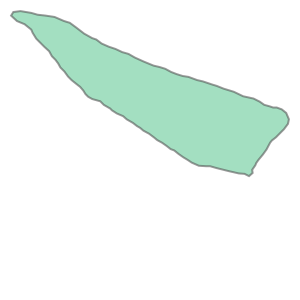

In [22]:
reference_shoreline = island_info['spatial_reference']['reference_shoreline']
shapely.geometry.Polygon(reference_shoreline)

In [164]:
area = [0.250081, 73.108371, 0.244389, 73.111383]
east = area[0]
north = area[1]
west = area[2]
south = area[3]
polygon = [[north, east], [south, east], [south, west], [north, west], [north, east]]

In [165]:
IslandTime.PreTimeSeries('Dherekudhehaa', 'Maldives', atoll='Gaafu Dhaalu', polygon=polygon).main()


-------------------------------------------------------------------
Retrieving general and spatial information about the island
Island: Dherekudhehaa, Maldives
-------------------------------------------------------------------

~ All information will be extracted/calculated. ~
Island not available in OpenStreetMap. Will use other methods.
Coordinates from Wikipedia (lat/lon): 0.4166666666666667 73.16666666666667
Coordinates from GeoKeo (lat/lon): nan nan
S2 73
L5 0
L7 2
L8 54
L9 9
No other information available.
~ Retrieving information from Duvat & Magnan (2019). ~
Island not found in the database.


In [154]:
IslandTime.PreTimeSeries('Kunata', 'Maldives', atoll='Gaafu Dhaalu').main()


-------------------------------------------------------------------
Retrieving general and spatial information about the island
Island: Kunata, Maldives
-------------------------------------------------------------------

~ All information will be extracted/calculated. ~
S2 75
L5 0
L7 2
L8 54
L9 9
~ Retrieving information from Duvat & Magnan (2019). ~
Island not found in the database.


In [11]:
path = os.path.join(os.getcwd(), 'data', 'iod.json')
import json
dd = json.load(open(path))

In [42]:
date = [datetime.datetime(int(float(dd['items'][i]['x'])), 
                          month=int((float(dd['items'][i]['x']) - int(float(dd['items'][i]['x']))) * 12) + 1, 
                          day=int((float(dd['items'][i]['x']) - int(float(dd['items'][i]['x']))) * 31 + 1))
                          for i in range(len(dd['items']))]
iod = [float(dd['items'][i]['y']) for i in range(len(dd['items']))]

plt.plot(date, iod)
df_iod = pd.DataFrame(iod, index=date, columns=['iod']).groupby([pd.Grouper(freq='M')]).mean()

In [198]:
df2 = df1['preprocessed_timeseries']['optimal time period']['dict_timeseries']['coastline_position_transect_8']['monthly']
ts = df2[['coastline_position_transect_8', 'sea_level_anomaly', 'total_precipitation', 'sea_surface_temperature', 'mean_sea_level_pressure', '2_metre_temperature', 'wave_energy_of_combined_wind_waves_and_swell']]

In [169]:
df_iod.plot()
plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2023, 1, 1))
plt.axhline(0, color='k', alpha=0.5, linestyle='--')

In [168]:
plt.plot(df_iod.index, df_iod.iod, color='k')
plt.fill_between(df_iod.index, df_iod.iod, 0, where=df_iod.iod > 0, color='purple', alpha=0.5)
plt.fill_between(df_iod.index, df_iod.iod, 0, where=df_iod.iod < 0, color='green', alpha=0.5)
plt.xlim(datetime.datetime(2013, 1, 1), datetime.datetime(2023, 1, 1))


(15706.0, 19358.0)

In [199]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts['coastline_position_transect_8'], seasonal=13)
result = stl.fit()
result.trend

2014-11-30 00:00:00+00:00    84.635702
2014-12-31 00:00:00+00:00    84.669637
2015-01-31 00:00:00+00:00    84.710946
2015-02-28 00:00:00+00:00    84.763778
2015-03-31 00:00:00+00:00    84.826106
                               ...    
2022-04-30 00:00:00+00:00    77.051949
2022-05-31 00:00:00+00:00    76.550159
2022-06-30 00:00:00+00:00    76.040818
2022-07-31 00:00:00+00:00    75.522157
2022-08-31 00:00:00+00:00    74.995910
Freq: M, Name: trend, Length: 94, dtype: float64

In [206]:
plt.plot(ts['coastline_position_transect_8'].index, ts['coastline_position_transect_8'].values, color='k')
plt.plot(ts['coastline_position_transect_8'].index, result.trend, color='r', label='trend analysis')

'''
# Indian Monsoon
for yr in range(2013, 2023):
    if yr == 2013:
        plt.fill_between(pd.date_range(datetime.datetime(yr, 4, 1), datetime.datetime(yr, 9, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='orange', alpha=0.2, label='Indian Monsoon')
    else:
        plt.fill_between(pd.date_range(datetime.datetime(yr, 4, 1), datetime.datetime(yr, 9, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='orange', alpha=0.2)
 '''
# El Nino
#plt.fill_between(pd.date_range(datetime.datetime(2015, 3, 1), datetime.datetime(2016, 5, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='r', alpha=0.2, label='2015/2016 El Nino')

# La Nina
#plt.fill_between(pd.date_range(datetime.datetime(2020, 8, 1), datetime.datetime(2021, 5, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='b', alpha=0.2, label='2020/2021 La Nina')

# 2021 storm
plt.axvline(datetime.datetime(2021, 5, 1), color='grey', linestyle='--', label='2021 storm')

# IOD positive
plt.fill_between(pd.date_range(datetime.datetime(2015, 1, 1), datetime.datetime(2016, 4, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='purple', alpha=0.2, label='positive IOD')
plt.fill_between(pd.date_range(datetime.datetime(2018, 12, 1), datetime.datetime(2020, 7, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='purple', alpha=0.2)

# IOD negative
plt.fill_between(pd.date_range(datetime.datetime(2016, 4, 1), datetime.datetime(2018, 12, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='green', alpha=0.2, label='negative IOD')
plt.fill_between(pd.date_range(datetime.datetime(2020, 7, 1), datetime.datetime(2022, 8, 1), freq='M'), min(ts['coastline_position_transect_8']), max(ts['coastline_position_transect_8']), color='green', alpha=0.2)

plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2022, 8, 1))
plt.legend()

In [61]:
plt.plot(ts['coastline_position_transect_6'], ts['total_precipitation'], 'o')

In [74]:
import seaborn as sns

In [76]:
sns.regplot(data = ts, x = 'coastline_position_transect_8', y ='sea_level_anomaly')

<Axes: xlabel='coastline_position_transect_8', ylabel='sea_level_anomaly'>

In [80]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)'%key] = value
    return result
    
ts.apply(adf_test, axis = 0)

,coastline_position_transect_8,sea_level_anomaly,total_precipitation,sea_surface_temperature,mean_sea_level_pressure,2_metre_temperature,wave_energy_of_combined_wind_waves_and_swell
Test Statistic,-4.925895,-3.729386,-8.637200e+00,-1.838609,-5.095649,-6.034048e+00,-2.237991
P-value,0.000031,0.003718,5.549446e-14,0.361469,0.000014,1.395755e-07,0.192747
Lags Used,4.000000,0.000000,0.000000e+00,12.000000,0.000000,5.000000e+00,11.000000
No of Observations,92.000000,96.000000,9.600000e+01,84.000000,96.000000,9.100000e+01,85.000000
Critical Value (1%),-3.503515,-3.500379,-3.500379e+00,-3.510712,-3.500379,-3.504343e+00,-3.509736
Critical Value (5%),-2.893508,-2.892152,-2.892152e+00,-2.896616,-2.892152,-2.893866e+00,-2.896195
Critical Value (10%),-2.583824,-2.583100,-2.583100e+00,-2.585482,-2.583100,-2.584015e+00,-2.585258


In [90]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_ielts = ccf_values(ts['wave_energy_of_combined_wind_waves_and_swell'], ts['coastline_position_transect_8'])
ccf_ielts

array([-2.85931110e-03, -2.52770811e-03,  1.92313478e-02,  2.58492237e-02,
        1.93432045e-02,  4.51015870e-03, -8.49969099e-03, -3.90869857e-02,
       -6.76287709e-02, -8.70060408e-02, -8.15150227e-02, -5.03735474e-02,
        3.23268987e-03,  5.53253326e-02,  1.00792563e-01,  1.08089129e-01,
        7.06030816e-02,  4.18643847e-03, -5.88816946e-02, -9.35966987e-02,
       -1.30778424e-01, -1.52381164e-01, -1.26039967e-01, -3.76278186e-02,
        4.09568103e-02,  1.33357308e-01,  1.75084034e-01,  1.96346048e-01,
        1.38635136e-01,  7.68942595e-02, -2.00439169e-02, -8.49267010e-02,
       -1.55643471e-01, -1.81308728e-01, -1.58825212e-01, -6.87933079e-02,
        4.02991293e-02,  1.25885475e-01,  1.96321292e-01,  2.14926627e-01,
        2.24794338e-01,  9.19014884e-02,  2.07014397e-02, -1.12221331e-01,
       -1.77940502e-01, -2.54023676e-01, -2.12290591e-01, -1.34709038e-01,
        7.47286403e-03,  1.68394465e-01,  2.26990349e-01,  2.69089661e-01,
        2.35161602e-01,  

In [91]:
import statsmodels
statsmodels.tsa.stattools.grangercausalitytests(ts[['wave_energy_of_combined_wind_waves_and_swell', 'coastline_position_transect_8']], maxlag=24)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8220  , p=0.0038  , df_denom=93, df_num=1
ssr based chi2 test:   chi2=9.1066  , p=0.0025  , df=1
likelihood ratio test: chi2=8.7002  , p=0.0032  , df=1
parameter F test:         F=8.8220  , p=0.0038  , df_denom=93, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9585  , p=0.0091  , df_denom=90, df_num=2
ssr based chi2 test:   chi2=10.4679 , p=0.0053  , df=2
likelihood ratio test: chi2=9.9303  , p=0.0070  , df=2
parameter F test:         F=4.9585  , p=0.0091  , df_denom=90, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4513  , p=0.0688  , df_denom=87, df_num=3
ssr based chi2 test:   chi2=7.9457  , p=0.0471  , df=3
likelihood ratio test: chi2=7.6276  , p=0.0544  , df=3
parameter F test:         F=2.4513  , p=0.0688  , df_denom=87, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3455  , p=0.2599  , df_d

{1: ({'ssr_ftest': (8.821993726490858, 0.003786574749331714, 93.0, 1),
   'ssr_chi2test': (9.106574169280885, 0.002546924334512347, 1),
   'lrtest': (8.700157058101752, 0.003181826339078901, 1),
   'params_ftest': (8.821993726490867, 0.003786574749331714, 93.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.958461641794639, 0.009060570926936169, 90.0, 2),
   'ssr_chi2test': (10.467863466010906, 0.005332517995155868, 2),
   'lrtest': (9.93029330546625, 0.0069769274485908936, 2),
   'params_ftest': (4.958461641794631, 0.00906057092693627, 90.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.451322662491182, 0.0687858132448009, 87.0, 3),
   'ssr_chi2test': (7.9456665611783155, 0.047148062306728106, 3),
   'lrtest': (7.627649581769788, 0.05436772649312271, 3),
   'params_ftest': (2.4513226624911195, 0.0687858132448068, 87.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [92]:
lags = signal.correlation_lags(len(ts['wave_energy_of_combined_wind_waves_and_swell']), len(ts['coastline_position_transect_8']))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation IElTS Search and Registeration Count', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_ielts)

In [52]:
col = 'coastline_position_transect_0'
df2[col].plot()
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(df2[col], lags=25, ax=ax)
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_pacf(df2[col], lags=25, ax=ax)
print(mk.original_test(df2[col].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.42479090505531136, z=-0.7981371498910443, Tau=-0.05742821473158552, s=-230.0, var_s=82322.0, slope=-0.010519514596271762, intercept=225.1649923156301)


In [100]:
from statsmodels.tsa.seasonal import STL
# Apply STL decomposition
stl = STL(df2['2_metre_temperature'], seasonal=13)
result = stl.fit()
fig = result.plot()

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid